# Built an end to end supervised ML pipeline using KNN, Logistic Regression and Naive Bayes to predict Loan approval implemented binary classification along with EDA and feature engineering and model evaluation(precision,recall,f1,accuracy)

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,f1_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [55]:
df = pd.read_csv("loan_approval_data.csv")
df.info()
# 950 non-null values so 50 null values are there
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Applicant_ID        950 non-null    float64
 1   Applicant_Income    950 non-null    float64
 2   Coapplicant_Income  950 non-null    float64
 3   Employment_Status   950 non-null    object 
 4   Age                 950 non-null    float64
 5   Marital_Status      950 non-null    object 
 6   Dependents          950 non-null    float64
 7   Credit_Score        950 non-null    float64
 8   Existing_Loans      950 non-null    float64
 9   DTI_Ratio           950 non-null    float64
 10  Savings             950 non-null    float64
 11  Collateral_Value    950 non-null    float64
 12  Loan_Amount         950 non-null    float64
 13  Loan_Term           950 non-null    float64
 14  Loan_Purpose        950 non-null    object 
 15  Property_Area       950 non-null    object 
 16  Educati

Applicant_ID          50
Applicant_Income      50
Coapplicant_Income    50
Employment_Status     50
Age                   50
Marital_Status        50
Dependents            50
Credit_Score          50
Existing_Loans        50
DTI_Ratio             50
Savings               50
Collateral_Value      50
Loan_Amount           50
Loan_Term             50
Loan_Purpose          50
Property_Area         50
Education_Level       50
Gender                50
Employer_Category     50
Loan_Approved         50
dtype: int64

## HANDLING MISSING VALUES

In [56]:
## in age we will fill with mean value
## in gender we will fill with mode value (the most frequent)

In [57]:
categorical_col = df.select_dtypes(include=["object"]).columns
numerical_col = df.select_dtypes(include=["float64"]).columns

In [58]:
num_imputer = SimpleImputer(strategy="mean")
df[numerical_col] = num_imputer.fit_transform(df[numerical_col]) # values are filled with mean

cat_imputer = SimpleImputer(strategy="most_frequent")
df[categorical_col] = cat_imputer.fit_transform(df[categorical_col]) # values are filled with mode strat

## EXPLORATORY DATA ANALYSIS (EDA)

Text(0.5, 1.0, 'is lone approved or not?')

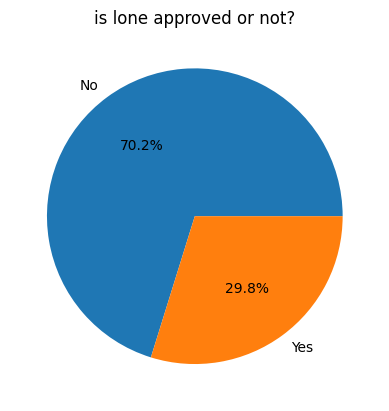

In [59]:
classes_cnt = df["Loan_Approved"].value_counts()
plt.pie(classes_cnt,labels=["No","Yes"],autopct="%1.1f%%")
plt.title("is lone approved or not?")

[Text(0, 0, '621'), Text(0, 0, '379')]

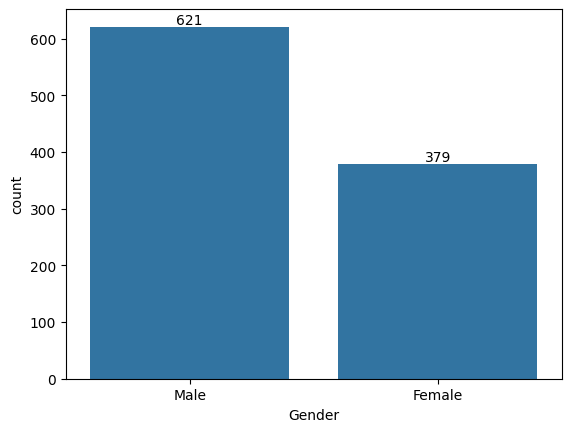

In [60]:
gender_cnt = df["Gender"].value_counts()
ax = sns.barplot(gender_cnt)
ax.bar_label(ax.containers[0])

[Text(0, 0, '722'), Text(0, 0, '278')]

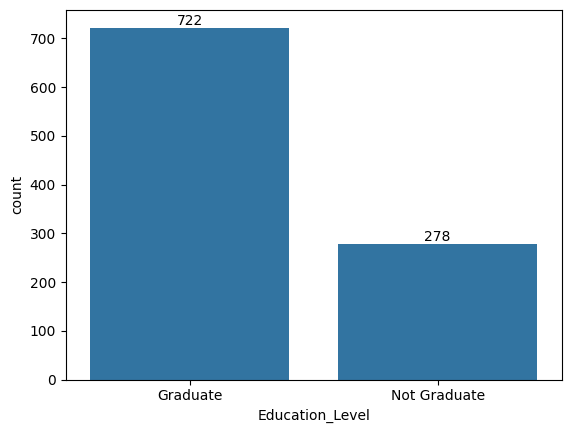

In [61]:
Education_Level_cnt = df["Education_Level"].value_counts()
ax = sns.barplot(Education_Level_cnt)
ax.bar_label(ax.containers[0])

<Axes: xlabel='Applicant_Income', ylabel='Count'>

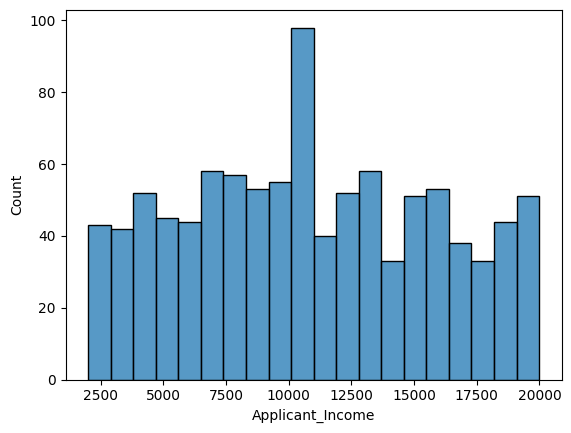

In [62]:
# analyze income
sns.histplot(
    data = df,
    x = "Applicant_Income",
    bins = 20
)

<Axes: xlabel='Credit_Score', ylabel='Count'>

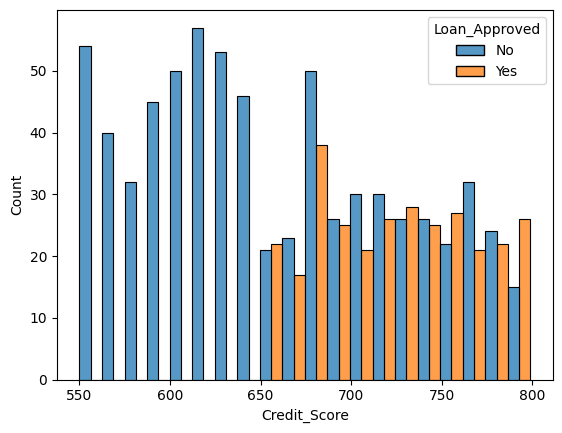

In [63]:
# relation of credit score with loan approve
sns.histplot(
    data = df,
    x = "Credit_Score",
    hue="Loan_Approved",
    bins=20,
    multiple="dodge"
)

In [64]:
# loans being approved above 650 score
# there high credit score, loan approval

In [65]:
df = df.drop("Applicant_ID", axis=1)

# ENCODING

In [66]:
# labelencoder assigns integer to each category
# one-hotencoder creates binary columns for each catergory 
# should use onehot since it gives every category a fair chance in training, doesnt create biasness

cols = ["Employment_Status","Marital_Status","Loan_Purpose","Property_Area","Gender","Employer_Category"] # for onehot
le = LabelEncoder()
df["Education_Level"] = le.fit_transform(df["Education_Level"]) # labelencoding
df["Loan_Approved"] = le.fit_transform(df["Loan_Approved"]) # labelencoding

In [67]:
cols = ["Employment_Status","Marital_Status","Loan_Purpose","Property_Area","Gender","Employer_Category"]
ohe = OneHotEncoder(drop="first",sparse_output=False,handle_unknown='ignore')
encoded = ohe.fit_transform(df[cols]) # will give 2D array
encoded_df = pd.DataFrame(encoded, columns=ohe.get_feature_names_out(cols),index=df.index)

In [68]:
encoded_df.head()

,Employment_Status_Salaried,Employment_Status_Self-employed,Employment_Status_Unemployed,Marital_Status_Single,Loan_Purpose_Car,Loan_Purpose_Education,Loan_Purpose_Home,Loan_Purpose_Personal,Property_Area_Semiurban,Property_Area_Urban,Gender_Male,Employer_Category_Government,Employer_Category_MNC,Employer_Category_Private,Employer_Category_Unemployed
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [69]:
#merging all the data
df = pd.concat([df.drop(columns=cols),encoded_df],axis=1)

In [70]:
df

,Applicant_Income,Coapplicant_Income,Age,Dependents,Credit_Score,Existing_Loans,DTI_Ratio,Savings,Collateral_Value,Loan_Amount,...,Loan_Purpose_Education,Loan_Purpose_Home,Loan_Purpose_Personal,Property_Area_Semiurban,Property_Area_Urban,Gender_Male,Employer_Category_Government,Employer_Category_MNC,Employer_Category_Private,Employer_Category_Unemployed
0,17795.000000,1387.0,51.0,0.0,637.0,4.0,0.53,19403.000000,45638.0,16619.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,2860.000000,2679.0,46.0,3.0,621.0,2.0,0.30,2580.000000,49272.0,38687.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,7390.000000,2106.0,25.0,2.0,674.0,4.0,0.20,13844.000000,6908.0,27943.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,13964.000000,8173.0,40.0,2.0,579.0,3.0,0.31,9553.000000,10844.0,27819.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,13284.000000,4223.0,31.0,2.0,721.0,1.0,0.29,9386.000000,37629.0,12741.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,10852.571579,9092.0,58.0,0.0,557.0,0.0,0.59,5370.000000,43563.0,8311.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
996,3279.000000,6356.0,58.0,1.0,646.0,3.0,0.19,9940.452632,18361.0,22563.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
997,15192.000000,8433.0,48.0,1.0,666.0,1.0,0.40,8581.000000,41335.0,16203.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
998,9083.000000,7380.0,50.0,1.0,748.0,3.0,0.31,13491.000000,8933.0,10290.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


## CORRELATION HEATMAP

In [71]:
# positive correlation means if x1 will increase x2 will increase two
# negative means decre
# 0 correlation means that two datas are not related at all and therefore increasement , decreasement wont affect each other

<Axes: >

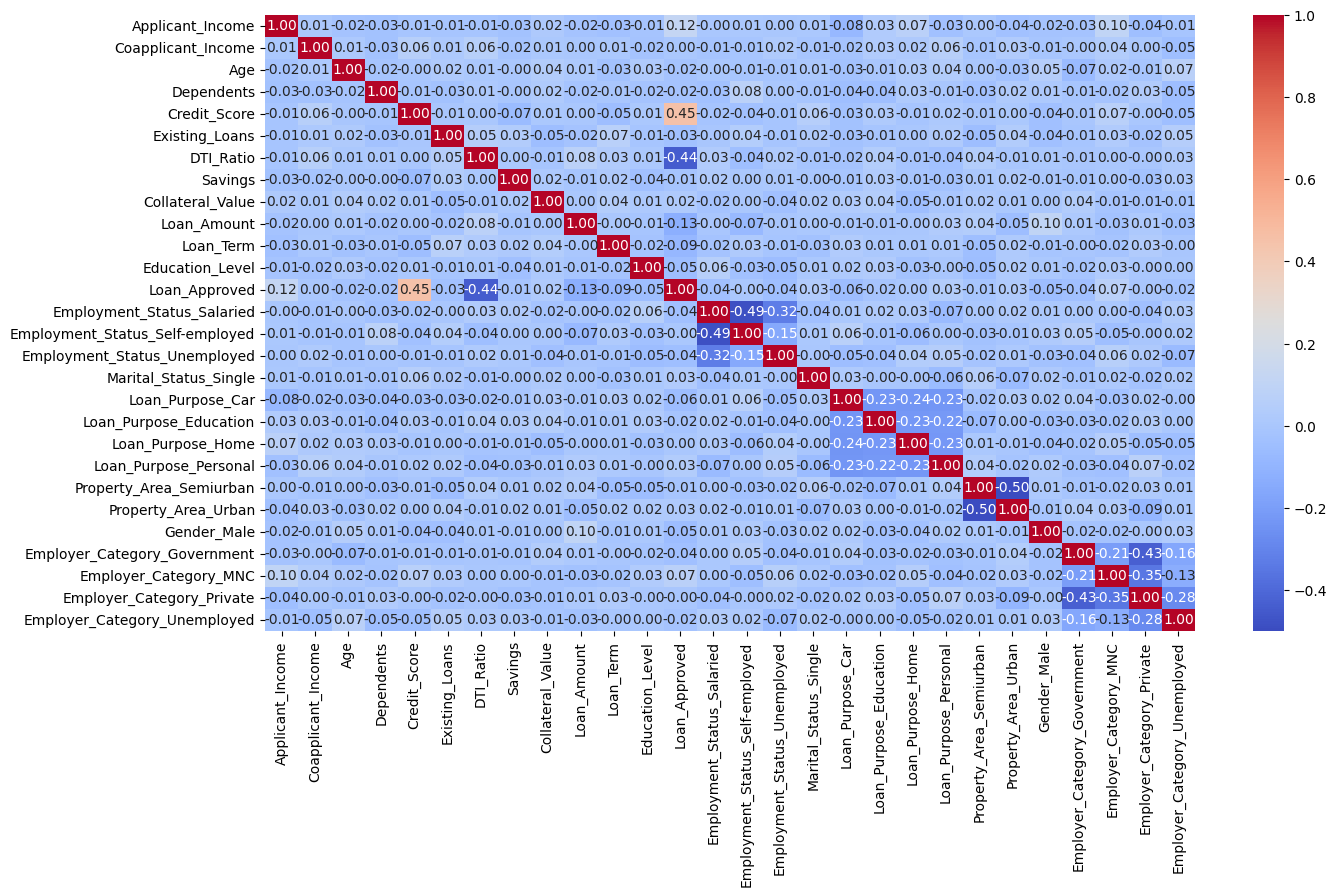

In [72]:
nums_col = df.select_dtypes(include="number")
corr_matrix = nums_col.corr()
plt.figure(figsize=(15,8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f", # upto two decimal places
    cmap="coolwarm"
)

## Train test split and scaling

In [73]:
X = df.drop("Loan_Approved",axis=1)
y = df["Loan_Approved"]
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.2,random_state=42
)

In [74]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# TRAIN AND EVALUATE MODEL


In [75]:
# logistic regression
log_model = LogisticRegression()
log_model.fit(X_train_scaled,y_train)
y_pred = log_model.predict(X_test_scaled)

In [76]:
# evaluation
print("Logistic regression model")
print("precision score: ",precision_score(y_test,y_pred))
print("recall score: ",recall_score(y_test,y_pred))
print("accuracy score: ",accuracy_score(y_test,y_pred))
print("cm: ",confusion_matrix(y_test,y_pred))
print("f1 score: ",f1_score(y_test,y_pred))

Logistic regression model
precision score:  0.7833333333333333
recall score:  0.7704918032786885
accuracy score:  0.865
cm:  [[126  13]
 [ 14  47]]
f1 score:  0.7768595041322314


In [77]:
# KNN
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

classifier = KNeighborsClassifier()
param_grid = {"knn__n_neighbors" : [1,3,5,7,9]} 
classifierCV = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring="recall"
)

classifierCV.fit(X_train,y_train) 
y_pred = classifierCV.predict(X_test)
print("recall score: ", recall_score(y_test,y_pred))
print("accuracy score: ", accuracy_score(y_test,y_pred))
print("precision score: ", precision_score(y_test,y_pred))
print("f1 score: ",f1_score(y_test,y_pred))
print(classifierCV.best_params_)

recall score:  0.5245901639344263
accuracy score:  0.69
precision score:  0.49230769230769234
f1 score:  0.5079365079365079
{'knn__n_neighbors': 1}


In [78]:
# we can see KNN algorithm didnt work better since we had a sparse dataset

In [79]:
# Naive bayes
gnb_model = GaussianNB()
gnb_model.fit(X_train_scaled,y_train)
y_pred = gnb_model.predict(X_test_scaled)
print("recall score: ", recall_score(y_test,y_pred))
print("accuracy score: ", accuracy_score(y_test,y_pred))
print("precision score: ", precision_score(y_test,y_pred))
print("f1 score: ",f1_score(y_test,y_pred))

recall score:  0.7377049180327869
accuracy score:  0.865
precision score:  0.8035714285714286
f1 score:  0.7692307692307693


In [80]:
# => best model on the basis of precision is Naive Bayes

# FEATURE ENGINEERING TO IMPROVE THE MODEL

In [81]:
# adding and transforming
df["DTI_Ratio_sq"] = df["DTI_Ratio"]**2
df["Credit_Score_sq"] = df["Credit_Score"]**2

X = df.drop(columns=["Loan_Approved","DTI_Ratio","Credit_Score_sq"])
y = df["Loan_Approved"]
X_train, X_test, y_train, y_test = train_test_split(
    X,y,test_size=0.2,random_state=42
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_model = LogisticRegression()
log_model.fit(X_train_scaled,y_train)
y_pred = log_model.predict(X_test_scaled)

In [82]:
print("Logistic regression model")
print("precision score: ",precision_score(y_test,y_pred))
print("recall score: ",recall_score(y_test,y_pred))
print("accuracy score: ",accuracy_score(y_test,y_pred))
print("cm: ",confusion_matrix(y_test,y_pred))
print("f1 score: ",f1_score(y_test,y_pred))

Logistic regression model
precision score:  0.7903225806451613
recall score:  0.8032786885245902
accuracy score:  0.875
cm:  [[126  13]
 [ 12  49]]
f1 score:  0.7967479674796748
